In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from sklearn.model_selection import train_test_split
import easyocr

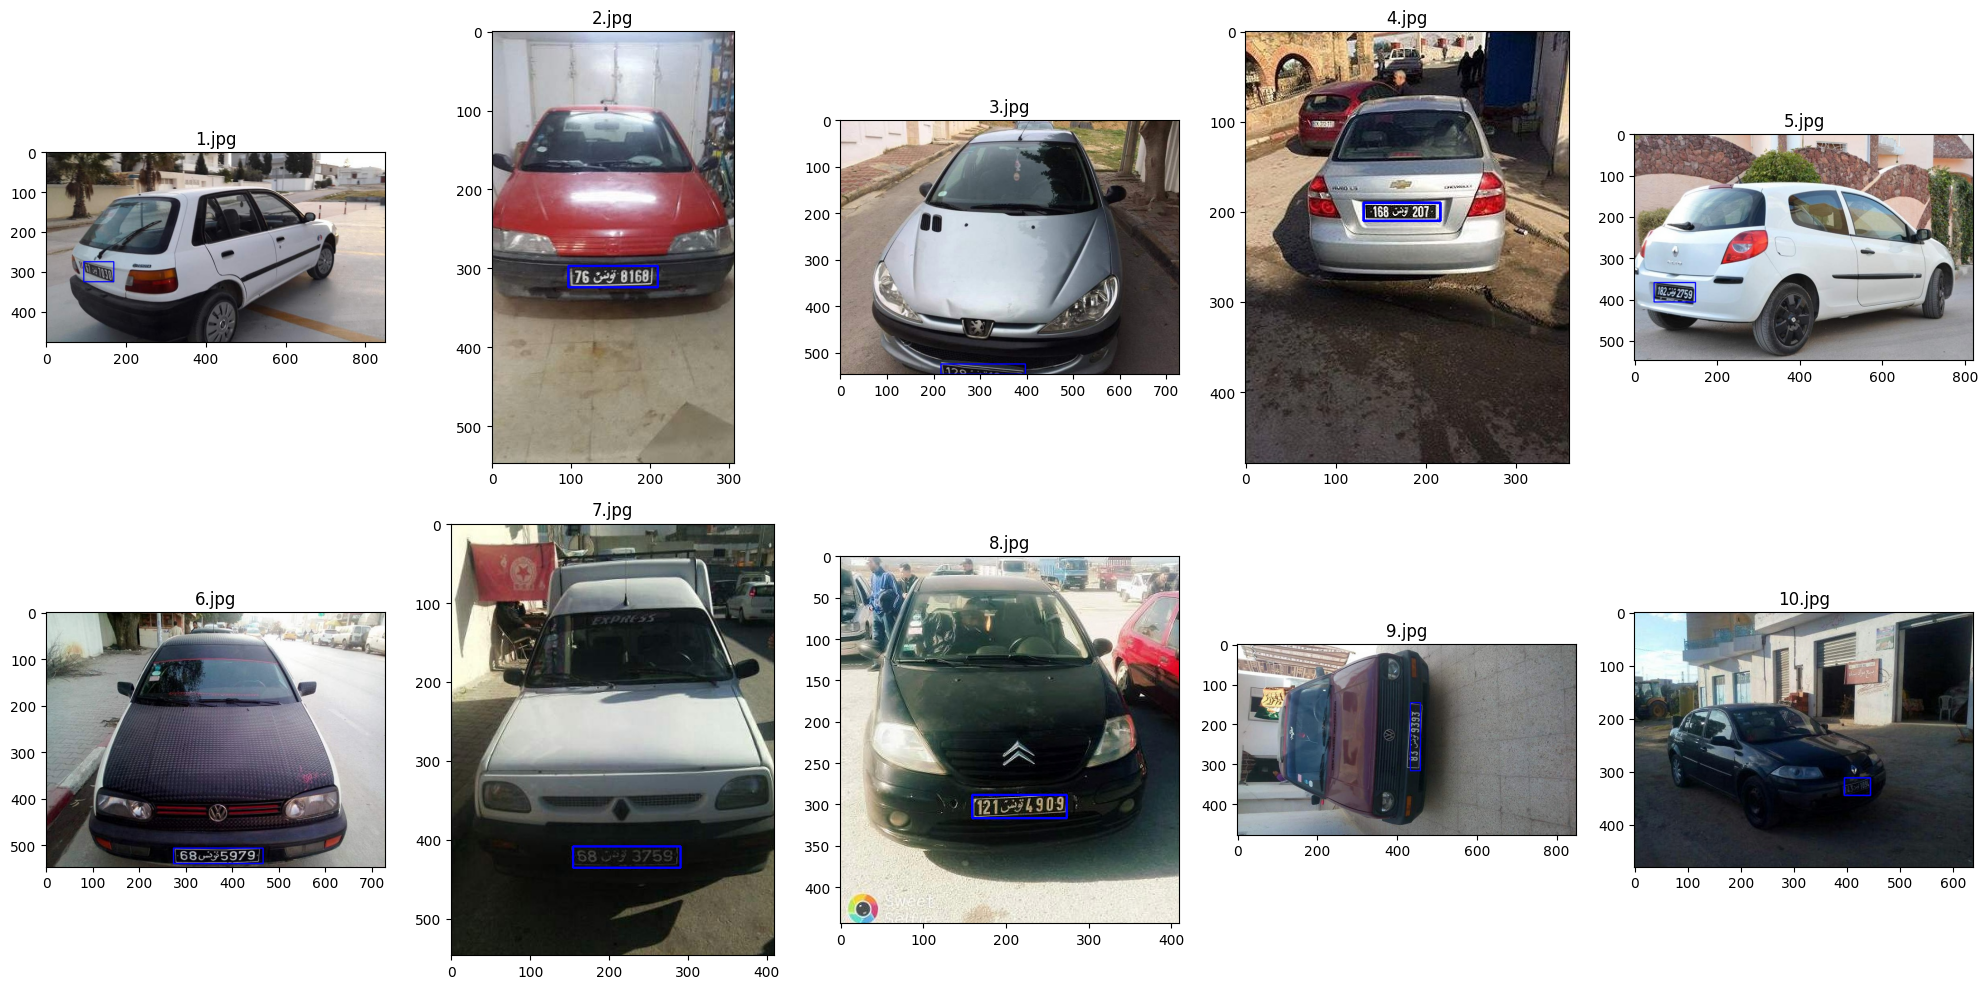

In [4]:
# loading the bounding box annotations
train1_annotations = pd.read_csv('train/atrain1.csv')
train2_annotations = pd.read_csv('train/atrain2.csv')

# training set 1
def display_vehicle_images(train1_annotations, image_folder):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    for i, row in train1_annotations.head(10).iterrows():
        img_path = os.path.join(image_folder, row['img_id'])
        img = cv2.imread(img_path)
        ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        axes[i // 5, i % 5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i // 5, i % 5].set_title(row['img_id'])
    plt.tight_layout()
    plt.show()
display_vehicle_images(train1_annotations,'train/train1')


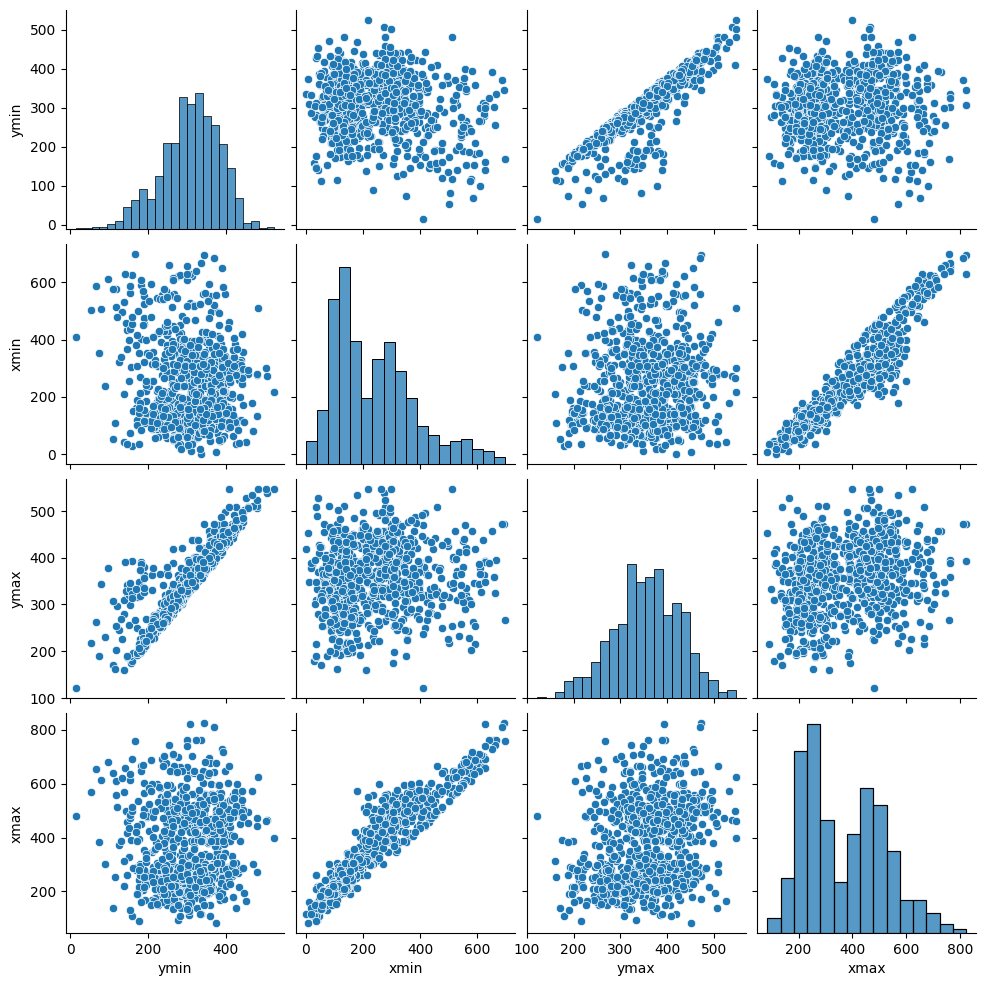

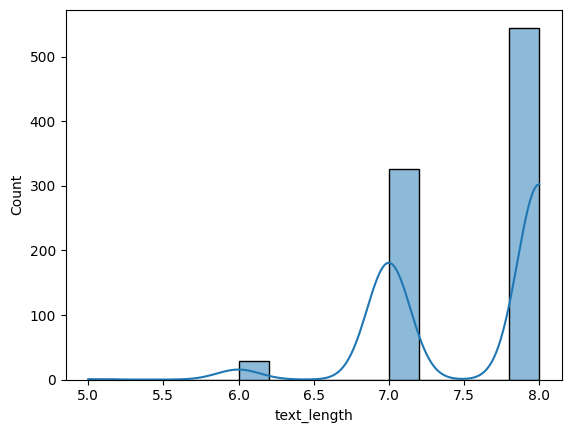

In [5]:
# Explore bounding box coordinates
sns.pairplot(train1_annotations[['ymin', 'xmin', 'ymax', 'xmax']])
plt.show()

# Explore text lengths in training set 2
train2_annotations['text_length'] = train2_annotations['text'].apply(len)
sns.histplot(train2_annotations['text_length'], kde=True)
plt.show()


In [3]:
# load the CSV file
df = pd.read_csv('train/atrain1.csv')

# create directories
os.makedirs('Licplatesdetection_train/images/train', exist_ok=True)
os.makedirs('Licplatesdetection_train/images/val', exist_ok=True)
os.makedirs('Licplatesdetection_train/labels/train', exist_ok=True)
os.makedirs('Licplatesdetection_train/labels/val', exist_ok=True)

# split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def convert_to_yolo_format(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def process_data(df, folder_type):
    for index, row in df.iterrows():
        img_path = row['img_id']
        img_full_path = f'train/train1/{img_path}'
        
        if not os.path.exists(img_full_path):
            print(f"File {img_full_path} does not exist.")
            continue
        
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        
        # load image to get its size
        img = Image.open(img_full_path)
        w, h = img.size
        
        # convert to YOLO format
        yolo_box = convert_to_yolo_format((w, h), (xmin, xmax, ymin, ymax))
        
        # save the image to the appropriate directory
        img.save(f'Licplatesdetection_train/images/{folder_type}/{os.path.basename(img_path)}')
        
        # save the label to the appropriate directory
        label_path = f'Licplatesdetection_train/labels/{folder_type}/{os.path.splitext(os.path.basename(img_path))[0]}.txt'
        with open(label_path, 'w') as f:
            f.write(f'0 {yolo_box[0]} {yolo_box[1]} {yolo_box[2]} {yolo_box[3]}\n')

# process training and validation data
process_data(train_df, 'train')
process_data(val_df, 'val')


In [27]:
input_image="test/976.jpg" # test the model with test data

Using cache found in C:\Users\nithi/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-6-7 Python-3.12.0 torch-2.3.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


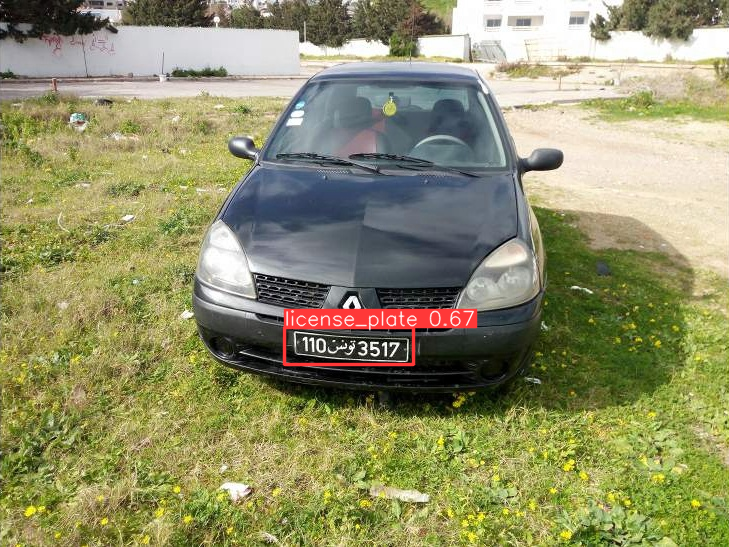

In [28]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp2/weights/best.pt')
def detect_license_plate(image_path):
    results = model(image_path)
    results.show()
detect_license_plate(input_image)     


In [29]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp2/weights/best.pt')
def recognize_and_format_plate(img_path):
    reader = easyocr.Reader(['en'], gpu=False)
    result = reader.readtext(img_path)
    recognized_text = result[0][1].split(" ")
    n = len(recognized_text)
    text = recognized_text[0] + 'T' + recognized_text[n-1]
    s = ""
    for char in text:
        if char.isdigit() or char == "T":
            s += char
    if(s[2]!="T"):
        s = s[:3] + "T" + s[-4:]
    else:
        s = s[:2] + "T" + s[-4:]
    return s

def detect_license_plate(image_path, output_path):
    results = model(image_path)
    results_df = results.pandas().xyxy[0]             # Convert results to pandas DataFrame
    image = cv2.imread(image_path)
    for index, row in results_df.iterrows():          # Draw bounding boxes and recognized text on the image
        x1, y1, x2, y2, conf, cls = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax']), row['confidence'], row['class']
        plate_image = image[y1:y2, x1:x2]             # Crop the detected plate region for OCR
        plate_path = 'temp_plate.jpg'
        cv2.imwrite(plate_path, plate_image)
        plate_text = recognize_and_format_plate(plate_path)        # Recognize and format the plate text
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)   # Draw bounding box
        cv2.putText(image, plate_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)    # Draw recognized text
    cv2.imwrite(output_path, image)   # Save the image with bounding boxes and text
     
output_image = 'output5.jpg'

detect_license_plate(input_image,output_image)  # Detect license plates and save the image with bounding boxes and recognized text

# Display the saved image with bounding boxes and text
output_img = Image.open(output_image)
output_img.show()


Using cache found in C:\Users\nithi/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-6-7 Python-3.12.0 torch-2.3.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Using CPU. Note: This module is much faster with a GPU.
